# An Introduction to Fisher Forecasting

*Zack Li, 7/27/2018*

As a cosmologist, you'll probably face the following question.

> Will this dataset be able to measure what I'm interested in?

More concrete examples from my own research include
* Will Planck lensing be useful for measuring properties of dark matter? 
* Should I run some N-body simulations which would take millions of CPU hours, in order to measure a parameter?
* Will the hierarchy of neutrino masses be tested with LSST galaxy lensing?
* Having performed a Monte Carlo analysis for a $\Lambda CDM$ extension using the latest CMB data, are my results plausible?

If your observables have **Gaussian uncertainties**, Fisher information matrices can help answer these questions. They perform the change of variables which turns uncertainties of correlated observables (i.e. the CMB power spectrum) into uncertainties of correlated parameters (i.e. the inputs for the $\Lambda CDM$ model). It is a crude (but useful!) error propagation, and applies to many cosmological data sets like CMB, weak lensing, and BAO.

![Image of ACTPol](../images/angelapano.jpg)

Since Fisher forecasting is a numerical technique, this guide is packaged as an interactive notebook. It's intended for advanced undergraduates and early graduate students, and the goal is to build intuition and be able to compute a Fisher matrix by the end. We'll cover the basic methods for computing Fisher information matrices, using the power spectrum of the cosmic microwave background (CMB) as an example. Useful references are [Coe 2009](https://arxiv.org/abs/0906.4123) for implementation tips, as well as the more comprehensive [Verde 2009](https://arxiv.org/abs/0911.3105) which I have drawn heavily from.

To use this notebook, you'll need to know a little calculus and cosmology, be able to state Bayes theorem, and have [CLASS](http://class-code.net/) installed with the Python wrapper.

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # I use a Mac

import numpy as np
import matplotlib.pyplot as plt
from classy import Class  # CLASS python wrapper

## A Change of Variables

Suppose you have some probability distribution $P(x)$ in terms of the variable $x$, and want to transform it so it's in terms of the variable $y$. What is  $Q(y)$, the transformed distribution? Changing variables should conserve the probability of a set of events, so in terms of differentials,

$$P(x) \, dx = Q(y) \, dy.$$

Dividing, we derive the familiar chain rule relating $P(x)$ and $Q(y)$,

$$P(x) = Q(y) \, \left|\frac{dy}{dx}\right|.$$

That is, you can transform probability distributions into new variables by using derivatives. In the case of multivariate Gaussian measurement uncertainty, the probability distributions can be described in terms of a covariance matrix. This is one way to interpret Fisher information matrix methods: you are **transforming the covariance matrix** describing your observables (i.e. measurement uncertainties) into the covariance matrix describing your parameters (i.e. uncertainties on numbers like $H_0$). 

What do you need to get there? Following the example above, you need to know the *covariance matrix* of your observable, and you need to know the *derivatives* between the observables and parameters. 

We now define the Fisher information matrix, $\mathbf{F}$, with elements $F_{ij}$. 

$$F_{ij} = - \left\langle\frac{\partial^2}{\partial \theta_i \theta_j} \mathrm{ln}\,f\right\rangle.$$

Here $f$ is the likelihood, and $\theta_i$ and $\theta_j$ are parameters you are interested in. Each element $F_{ij}$ of the Fisher information matrix is defined as the Hessian of the log likelihood, averaged over realizations of your data. This is a more geometric interpretion of the Fisher information matrix: it describes the **curvature of the log likelihood**. If the likelihood is "sharp" or "peaked", that means our experiment is very good at measuring the parameters. With such a peaked likelihood, the curvature of the log likelihood at the peak will be high. Similarly, if the likelihood is wide and spread out, the curvature will be low, as will the Fisher information.

![Sketch of curvature](../images/curvature_sketch.png)

The Fisher matrix is useful because of the *Cramér-Rao Bound*, which states that the variance of an unbiased estimator is at least as high as the inverse of the Fisher information matrix. For parameters $x$ and $y$, the covariance $\sigma_{xy}$ is bounded with the inequality

$$\sigma_{xy} \geq F_{xy}^{-1}.$$

In other words, the inverse of the Fisher information matrix gives you best possible covariance matrix for the parameters you are trying to estimate. A nice informal derivation of this fact is on the [Wikipedia page](https://en.wikipedia.org/wiki/Fisher_information) for Fisher information.

We now return to the change of variables interpretation. Recall that the probabilities must sum to 1, so that $\int f\, d^n\theta = 1$. Taking a derivative of this identity and combining with the definition of the Fisher information matrix, one can derive the transformation rule for a set of variables $\{\lambda_i\}$ to the set $\{\theta_i\}$ for the Fisher matrix (more details in [Tegmark 1996](https://arxiv.org/abs/astro-ph/9611174)),

$$ \mathbf{F}^{\theta} = \mathbf{J}^T \mathbf{F}^{\theta} \mathbf{J},$$

The matrix $\mathbf{J}$ is the Jacobian, with elements $J_{ij} \equiv \frac{\partial \lambda_i}{\partial \theta_j}$.

## Our Example: The CMB Power Spectrum

We've been speaking generally about covariances and derivatives. We'll now make a brief detour and discuss the main example of this notebook, the angular power spectrum $C_{\ell}$ of the fluctuations in the cosmic microwave background (CMB). There are many details here, and I'd recommend a textbook like *Modern Cosmology* by Dodelson if you want to learn more.

A short summary which might stir some memories if you've taken a cosmology course: 

* The CMB has fluctuations on the order of $10^{-4}$ in temperature and polarization, and the statistical properties of the fluctuations depend on cosmological parameters like the cold dark matter density $\Omega_c$, the baryon density $\Omega_b$, and the amplitude of the primordial perturbations $A_s$.
* Since the CMB is on the (spherical) sky, these fluctuations can be decomposed into the spherical harmonics, which form an orthonormal and complete basis. The decomposition yields coefficients $a_{\ell m}$. 
* The CMB map is a Gaussian random field (GRF), which for our purposes means the $a_{\ell m}$ are independent and Gaussian-distributed over different realizations of the universe. We can characterize the statistical properties of the CMB with a variance $C_{\ell}$, by averaging the spherical harmonic coefficients over noise realizations of the CMB,
$$\langle a_{\ell m} a_{\ell' m'} \rangle = \delta_{\ell \ell'} \delta_{m m'} C_{\ell}.$$

We don't need a very detailed knowledge of this to make progress here; if you want, just think of $C_{\ell}$ just as a set of numbers you can measure, indexed by $\ell$. The Boltzmann code CLASS can generate theory curves of $C_{\ell}$ given a set of cosmological parameters. Let's generate the $\Lambda CDM$ temperature (TT) spectrum now with CLASS. We'll name it `fiducial` because we'll use it later as the fiducial power spectrum for Fisher forecasts.

In [7]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': 2000,
    'lensing': 'yes',
    'omega_cdm': 0.120,
    'omega_b': 0.0224, 
    'h': 0.674,
}

# The usual CLASS code for computing C_ell
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.lensed_cl(2000)
cosmo.struct_cleanup()
cosmo.empty()

We are choosing a parametrization $\{ \omega_{cdm}, \omega_b, h\}$ with $\omega_{cdm} = \Omega_{c} h^2$, $\omega_{b} = \Omega_{b} h^2$, $h = H_0 / (100\:\mathrm{km/s/Mpc})$. Let's plot it in a common way to view power spectra, $\ell^2 C_{\ell}^{TT}$. The $\ell^2$ factor is so you can see the high-$\ell$ features, which are hard to see otherwise due to Silk damping.

In [8]:
fiducial.keys()

dict_keys(['tt', 'ee', 'te', 'bb', 'pp', 'tp', 'ell'])

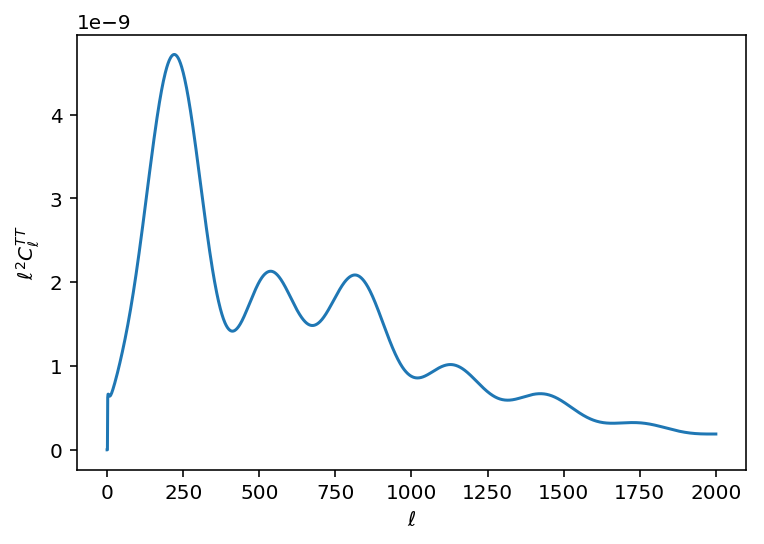

In [9]:
plt.plot(fiducial['ell'], fiducial['ell']**2*fiducial['tt'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2 C_{\ell}^{TT}$');

## Compute a Derivative
We've suggested that derivatives are important for a change of variables. For the CMB, we can actually write the Fisher matrix for the parameters in terms of the Fisher matrix for $C_{\ell}$, which we'll describe later. We can write the transformation rule as

$$ \mathbf{F}^{\theta} = \mathbf{J}^T \mathbf{F}^{C_{\ell}} \mathbf{J}.$$

The variable we have is $C_{\ell}$, and the variables we want are a set of cosmological parameters $\{ \theta_i \}$, for example the normalized Hubble constant $h$. Thus, we will be interested in computing a Jacobian $\mathbf{J}$ which corresponds to 

$$ \frac{\partial C_{\ell}^{XY}}{\partial \theta_i} $$

for observable $XY \in \{ TT, TE, EE \}$. As an example, we will now estimate $\partial C_{\ell}^{TT} / \partial h$, the derivative of the TT power spectrum with respect to the normalized Hubble constant. This is just a matter of choosing a step size $\Delta h$, and then computing $\Delta C_{\ell} / \Delta h$.

Good step sizes for Fisher typically are $\sim 1\%$ of the parameter itself. Smaller steps are usually better for the derivative, but going too small can lead to numerical instability.

In [10]:
def utility_function_call_CLASS(input_dict, l_max=2000):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.lensed_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl


# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': 2000,
    'lensing': 'yes',
    'omega_cdm': 0.120,
    'omega_b': 0.0224, 
    'h': 0.674
}

# for left and right sides of the derivative, copy
# the dict above, and then change the parameter
# we are interested in. 
h_step = 0.01
left_params = params.copy()
left_params['h'] = params['h'] - h_step
right_params = params.copy()
right_params['h'] = params['h'] + h_step

# get the C_l^TT and then compute the derivative!
cl_tt_left = utility_function_call_CLASS(left_params)['tt']
cl_tt_right = utility_function_call_CLASS(right_params)['tt']
dCltt_dh = (cl_tt_right - cl_tt_left) / (2 * h_step)

Let's plot the derivative! We'll plot it but normalize by $C_{\ell}^{TT}$ so it's more clear. The warning message below is just because the CLASS output has zeroes for $\ell < 3$.

/usr/licensed/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


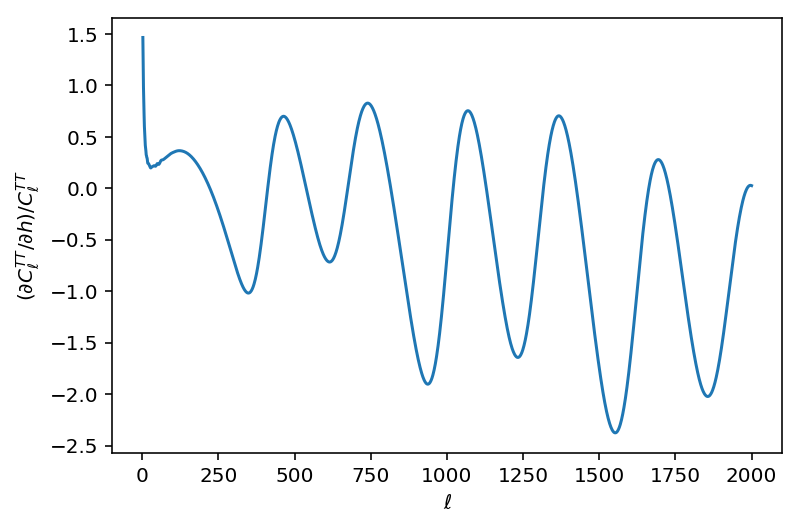

In [11]:
plt.plot( dCltt_dh / fiducial['tt'] )
plt.ylabel(r'$(\partial C_{\ell}^{TT} / \partial h) / C_{\ell}^{TT}$')
plt.xlabel(r'$\ell$');

-----
## Assignment 1
Write a function `get_deriv()` which takes in a parameter name (like `omega_b`), a channel (like `'tt'`), and a stepsize (like `0.01`) and returns the derivative $\partial C_{\ell}^{XY} / \partial \theta_i$. Test it out by reproducing the plot above.

In [20]:
# fill me in!
def get_deriv(params, param, stepsize, channel = ""):
    '''
    params - dictionary with parameters
    param - [string] parameter you would want to vary, e.g. 'h'
    channel - [string] a kind of Cl you would want to get derivative of, e.g.'tt'
    stepsize - [float/int] a step away from the point of calculating derivative
    '''
    left_params = params.copy()
    left_params[param] = params[param] - stepsize
    right_params = params.copy()
    right_params[param] = params[param] + stepsize
    cl_ch_left = utility_function_call_CLASS(left_params)
    cl_ch_right = utility_function_call_CLASS(right_params)
    if channel != "":
        # get the C_l^channel and then compute the derivative!
        dCltt_dh = (cl_ch_right[channel] - cl_ch_left[channel]) / (2 * stepsize)
        return dCltt_dh
    else:
        dCltt_dh = (cl_ch_right['tt'] - cl_ch_left['tt']) / (2 * stepsize)
        dCltp_dh = (cl_ch_right['te'] - cl_ch_left['te']) / (2 * stepsize)
        dClpp_dh = (cl_ch_right['ee'] - cl_ch_left['ee']) / (2 * stepsize)
        return dCltt_dh, dCltp_dh, dClpp_dh

/usr/licensed/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


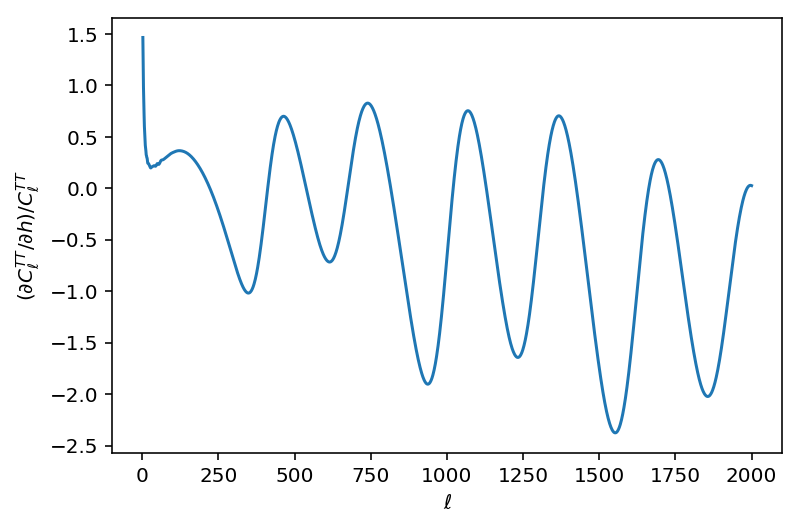

In [21]:
dCltt_dh = get_deriv(params, 'h', 0.01, 'tt')

plt.plot( dCltt_dh / fiducial['tt'] )
plt.ylabel(r'$(\partial C_{\ell}^{TT} / \partial h) / C_{\ell}^{TT}$')
plt.xlabel(r'$\ell$');


In [22]:
len(fiducial['ell'])
fiducial['ell'][2000]

2000

-----

## Nice Gaussian Facts

We now have to revisit the angle brackets in the definition of the Fisher information matrix. Here is the definition again,

$$F_{ij} = - \left\langle\frac{\partial^2}{\partial \theta_i \theta_j} \mathrm{ln}\,f\right\rangle.$$

The $\langle \cdots \rangle$ refer to an average over *data realizations*, or in other words, an average of each possible way that the data could have turned out given the assumed noise properties. For continuous variables, this requires taking an integral in data space that is weighted by the probability density of obtaining that data. In the case of CMB data, the power spectrum can have order 50 bins, thus requiring a 50-dimensional integral. Cancel.

If the measurement uncertainty is described by a multivariate Gaussian, then we can avoid doing this (see [Tegmark et al. 1996](https://arxiv.org/abs/astro-ph/9603021) for the derivation in the CMB context, an identical derivation exists for lensing). The signal in the sky for temperature (T) as well as curl-free (E) and divergence-free (B) polarization (i.e. E and B modes) then consists of a set over $m$, 

$$ (a_{\ell}^T, a_{\ell}^E, a_{\ell}^B)$$

We don't have multiple skies, but a GRF has the nice property that we can estimate the variance on $a_{\ell m}$ by looking at different parts of the sky. Unfortunately this estimator is limited by the sample size for a specific angle scale on the sky, and we have only $2 \ell + 1$ samples. There is uncertainty on the estimate of $C_{\ell}$, we have $(\Delta C_{\ell})^2  = \frac{2}{2\ell+1} C_{\ell}^2$. This is the so-called *cosmic variance*.

We therefore have for each positive integer $\ell$ an observable $C_{\ell}$ that we can measure. The observable $C_{\ell}$ has intrinsic variance $(\Delta C_{\ell})^2 = \frac{2}{2\ell+1} C_{\ell}^2$. Assuming that the B-modes are negligible :( we can write for correlated T and E spectra a matrix proportional to the covariance for each $\ell$,

$$ \mathbf{C}_{\ell} \equiv 
  \left( {\begin{array}{cc}
   C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} \\
  \end{array} } \right)
 $$

where $N_{\ell}^{TT}$ and $N_{\ell}^{EE}$ refer to additional instrumental noise in the temperature and polarization, which are added to the noise from cosmic variance. The cross-spectrum noise $N_{\ell}^{TE}$ is usually negligible for typical CMB experiments, so we have assumed $N_{\ell}^{TE} = 0$. Then the Fisher matrix can be expressed as a sum over each $\ell$, 

$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$

Here, $f_{\mathrm{sky}}$ refers to the fraction of the sky which the experiment covers, since you can think of the $a_{\ell m}$ as having $(2 \ell + 1)f_{\mathrm{sky}}$ samples to work with. The ($\mathrm{Tr}$) refers to the trace of the matrix. You might consult [Wu et al. 2014](https://arxiv.org/abs/1402.4108) if you need a second description.

## Teach a cosmologist how to fish, and...

Now you'll compute your own Fisher matrix. Let's start with a full-sky, cosmic variance-limited (CV-limited) experiment. In a CV-limited experiment, we have $N_{\ell}^{TT} = 0$ and $N_{\ell}^{EE} = 0$. This is the best-possible CMB experiment we could ever make.

----
## Assignment 2

Using the `fiducial` CLASS object we computed earlier, print out the $2 \times 2$ matrix $\mathbf{C}_{\ell}$ for $\ell = 1000$. Convert it into a numpy array, and then print its inverse too.

In [23]:
# you might use for example...
fiducial['ell'][100]

100

In [24]:
w, h = 2, 2
ell = 1000
Matrix = [[0 for x in range(w)] for y in range(h)] 
Matrix[0][0] = fiducial['tt'][ell]
Matrix[0][1] = fiducial['te'][ell]
Matrix[1][0] = fiducial['te'][ell]
Matrix[1][1] = fiducial['ee'][ell]
Matrix # Cl matrix for l=1000

[[8.767488202506445e-16, -1.8087922347096594e-17],
 [-1.8087922347096594e-17, 3.4600544240094343e-17]]

In [25]:
Cl_100 = np.array(Matrix)
Cl_100_inv = np.linalg.inv(Cl_100)
print(Cl_100_inv) #Cl inverse matrix
#print(np.matmul(Cl_100, Cl_100_inv))

[[1.15301274e+15 6.02753668e+14]
 [6.02753668e+14 2.92163775e+16]]


In [26]:
def get_cl_and_inv(ell, fiducial):
    Matrix = [[0 for x in range(2)] for y in range(2)] 
    Matrix[0][0] = fiducial['tt'][ell]
    Matrix[0][1] = fiducial['te'][ell]
    Matrix[1][0] = fiducial['te'][ell]
    Matrix[1][1] = fiducial['ee'][ell]
    Cl = np.array(Matrix)
    Cl_inv = np.linalg.inv(Cl)
    return Cl, Cl_inv

$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$


## Assignment 3
Compute a single element of the Fisher matrix, where $\theta_i = \omega_b$ and $\theta_j = h$. Use your derivative function you wrote earlier, and perform the matrix multiplications! Remember to sum over $\ell$.

In [28]:
def get_deriv_matrix(dCltt_dparam, dClte_dparam, dClee_dparam,l):
    Matrix = [[0 for x in range(2)] for y in range(2)] 
    Matrix[0][0] = dCltt_dparam[l]
    Matrix[0][1] = dClte_dparam[l]
    Matrix[1][0] = dClte_dparam[l]
    Matrix[1][1] = dClee_dparam[l]
    dCl_dparam = np.array(Matrix)
    return dCl_dparam



In [29]:
#'omega_cdm': 0.120 - Parameters to remember to choose sensible stepsize
#'omega_b': 0.0224

sum_F = 0.
param1 = 'omega_cdm'
param2 = 'omega_b'
f_sky = 1.0
l = 2
dCltt_dparam1, dCltp_dparam1, dClpp_dparam1 = get_deriv(params, param1, 0.005)

dCltt_dparam2, dCltp_dparam2, dClpp_dparam2 = get_deriv(params, param2, 0.001)

term = (2*l +1)*f_sky/2
Cl, Cl_inv = get_cl_and_inv(l, fiducial)
dCl_b = get_deriv_matrix(dCltt_dparam1, dCltp_dparam1, dClpp_dparam1,l)
dCl_cdm = get_deriv_matrix(dCltt_dparam2, dCltp_dparam2, dClpp_dparam2,l)
Matrix = Cl_inv @ dCl_b @ Cl_inv @ dCl_cdm
Tr = np.trace(Matrix)
term = term * Tr
sum_F = sum_F + term
sum_F

-1882.5129470294721

In [30]:
sum_F = 0. # element of fisher materix
param1 = 'omega_cdm'
param2 = 'h'
f_sky = 1.0

dCltt_dparam1, dClte_dparam1, dClee_dparam1 = get_deriv(params, param1, 0.005)
dCltt_dparam2, dClte_dparam2, dClee_dparam2 = get_deriv(params, param2, 0.01)

for l in range(2, 2001):
    term = (2*l +1)*f_sky/2
    Cl, Cl_inv = get_cl_and_inv(l, fiducial)
    dCl_b = get_deriv_matrix(dCltt_dparam1, dCltp_dparam1, dClpp_dparam1,l)
    dCl_cdm = get_deriv_matrix(dCltt_dparam2, dCltp_dparam2, dClpp_dparam2,l)
    Matrix = Cl_inv @ dCl_b @ Cl_inv @ dCl_cdm
    Tr = np.trace(Matrix)
    term = term * Tr
    sum_F = sum_F + term

print(sum_F)
    

-506443998.25004894


## Assignment 4
Compute the full Fisher matrix over the set of parameters $\{ \omega_{cdm}, \omega_b, h \}$. That is, $F_{01}$ would refer to $\theta_0 = \omega_{cdm}$, and $\theta_1 = \omega_{b}$, and so on.

In [32]:
param_set = {0:'omega_cdm',1:'omega_b',2:'h'}
f_sky = 1.0
w, l = len(param_set), len(param_set)
Matrix_f = [[0 for x in range(w)] for y in range(l)]
dCl = []
dCl.append(get_deriv(params, param_set[0], 0.005))
dCl.append(get_deriv(params, param_set[1], 0.001))
dCl.append(get_deriv(params, param_set[2], 0.01))

#dCltt_dparam2, dCltp_dparam2, dClpp_dparam2 = get_deriv(params, param_set[1], 0.001)
#dCltt_dparam3, dCltp_dparam3, dClpp_dparam3 = get_deriv(params, param_set[2], 0.01)


In [33]:
for i in range(len(param_set)):
    for j in range(len(param_set)):
        sum_F = 0
        for l in range(2, 2001):
            term = (2*l+1)*f_sky/2
            Cl, Cl_inv = get_cl_and_inv(l, fiducial)
            dCl_param1 = get_deriv_matrix(dCl[i][0],dCl[i][1],dCl[i][2],l)
            dCl_param2 = get_deriv_matrix(dCl[j][0],dCl[j][1],dCl[j][2],l)
            Matrix = Cl_inv @ dCl_param1 @ Cl_inv @ dCl_param2
            Tr = np.trace(Matrix)
            term = term * Tr
            sum_F = sum_F + term
        Matrix_f[i][j] = sum_F
            
        

In [35]:
Fisher = np.array(Matrix_f)
print(Fisher)

[[ 3.10262066e+08 -5.66562434e+08  8.06525936e+07]
 [-5.66562434e+08  2.37118828e+09 -1.68717988e+08]
 [ 8.06525936e+07 -1.68717988e+08  2.17616980e+07]]


## Assignment 5
Print out your covariance! Recall that the best possible covariance of your parameters is the inverse of the Fisher matrix,

$$ \mathrm{Cov} = F^{-1} .$$

This corresponds to the covariance matrix for a multivariate Gaussian which describes your parameters, also called the posterior. The ellipses one usually sees for Fisher forecasts are just 2D marginalized 1- and 2-$\sigma$ contours. The 1-$\sigma$ constraints marginalized over all other parameters (i.e. the error quoted in the $X \pm \sigma$) is the square root of the diagonal of the covariance matrix, i.e. $\sigma_i = \sqrt{\mathrm{Cov}_{ii}}$. What's the error bar on your experiment for $h$?

In [36]:
cov = np.linalg.inv(Fisher)
print(cov)

[[ 1.23385665e-07 -6.81682406e-09 -5.10139179e-07]
 [-6.81682406e-09  1.31724309e-09  3.54768798e-08]
 [-5.10139179e-07  3.54768798e-08  2.21166729e-06]]


In [37]:
err_h = np.sqrt(cov[2][2])
err_h

0.0014871675391980757

## Assignment 6
Finally, we'll perform a more realistic forecast! We'll add in the noise terms $N_{\ell}^{TT}$ and $N_{\ell}^{EE}$. My favorite reference for this is [Wu et al. 2014](https://arxiv.org/abs/1402.4108). White noise curves can be generated with
$$N_\ell^{XX'} = s^2 \text{exp} \left( \ell(\ell+1) \frac{\theta^2_\mathrm{FWHM}}{8 \ln 2} \right),$$
where $s$ is the noise level in $\mu K$-radians, and $\theta_\mathrm{FWHM}$ is the beam width in radians. A common forecasting prescription for Planck has temperature noise level $s_T = 33 \mu \mathrm{K}$-arcmin, polarization noise level $s_P = \sqrt{2} s_T$, and the beam $\theta_{FWHM} = 7$ arcmin. Importantly, you must remove a factor of $10^{-6} T_{cmb} / \mathrm{Kelvin}$ to match the unitless output of CLASS, or vice versa. Make a forecast for Planck 2015!

In [76]:
sT = 33 * (np.pi/60./180.)*10**(-6)
sP = sT * np.sqrt(2.)
theta_FWHM = 7. * (np.pi/60./180.)

In [77]:
N_tt = []
for l in range(2, 2001):
    Ntt = (sT**2)*np.exp(l*(l+1)*(theta_FWHM**2)/(8*np.log(2)))
    N_tt.append(Ntt)
N_tt = np.array(N_tt)

In [78]:
N_ee = []
for l in range(2, 2001):
    Nee = (sP**2)*np.exp(l*(l+1)*(theta_FWHM**2)/(8*np.log(2)))
    N_ee.append(Nee)
N_ee = np.array(N_ee)

In [79]:
param_set = {0:'omega_cdm',1:'omega_b',2:'h'}
f_sky = 1.0
width, length = len(param_set), len(param_set)
Matrix_noise = [[0 for x in range(width)] for y in range(length)]
for i in range(len(param_set)):
    for j in range(len(param_set)):
        sum_F = 0
        for l in range(2, 2001):
            term = (2*l+1)*f_sky/2
            Cl, Cl_inv = get_cl_and_inv(l, fiducial)
            Cl[0][0] = Cl[0][0]+N_tt[l-2]
            Cl[1][1] = Cl[1][1]+N_ee[l-2]
            Cl_inv=np.linalg.inv(Cl)
            dCl_param1 = get_deriv_matrix(dCl[i][0],dCl[i][1],dCl[i][2],l)
            dCl_param2 = get_deriv_matrix(dCl[j][0],dCl[j][1],dCl[j][2],l)
            Matrix = Cl_inv @ dCl_param1 @ Cl_inv @ dCl_param2
            Tr = np.trace(Matrix)
            term = term * Tr
            sum_F = sum_F + term
        Matrix_noise[i][j] = sum_F
print(np.array(Matrix_noise))

[[ 1.47567540e+07 -8.27340745e+06  3.03113848e+06]
 [-8.27340745e+06  1.82711095e+08 -5.46067303e+06]
 [ 3.03113848e+06 -5.46067303e+06  7.65162653e+05]]


In [80]:
cov = np.linalg.inv(Matrix_noise)
print(cov)

[[ 6.63302447e-07 -6.16447393e-08 -3.06756129e-06]
 [-6.16447393e-08  1.26860096e-08  3.34736530e-07]
 [-3.06756129e-06  3.34736530e-07  1.58477283e-05]]


In [81]:
err_h = np.sqrt(cov[2][2])
err_h

0.003980920530082204

Once you've calculated a covariance matrix, it's straightforward to make triangle plots like below, as the math is just collapsing down the multivariate Gaussian you've computed. The implementation details for making pretty ellipses are in the very helpful [Coe 2009](https://arxiv.org/abs/0906.4123).

<img src="../images/basic_output.png" width="300" height="300" title="basic triangle plot">

## Bonus Material: Noise Plots

It's sometimes useful to see visualize what's happening with Fisher matrices. Here I describe one way, where you plot the signal and noise curves. The binned variance (for a `binsize` perhaps of 100-200) can be written

$$ \sigma_{C_{\ell}}^2 = \frac{1}{N_{bin}}  \frac{2}{(2 \ell + 1)f_{sky}}  \left(N_{\ell}^2 + C_{\ell}^2 \right) , $$

Basically the term in the $\mathbf{C_{\ell}}$ elements that go into $F_{ij}$. It is often convenient to plot the quantities $\Delta C_{\ell} / C_{\ell}$ and $\sigma_{C_{\ell}} / C_{\ell}$.


-----
## Some Dire Warnings

Fisher forecasts are pretty crude estimates of the posterior. They will fail for all sorts of reasons, in particular

1. **Noisy derivatives**. Fisher codes can unfortunately be sensitive to the step-size used in computing the derivative. In order to make robust forecasts, always make sure to check that your forecasts do not fluctuate too much in terms of the stepsize, and that your derivatives do not suffer from numerical error from using too small a step-size. This can sometimes be solved by increasing the precision parameters of the code which makes your theory curves.
2. **Non-Gaussian posteriors and priors**. If your parameters relate to each other in banana shapes on a triangle plot, the Fisher forecast can be very wrong (probably at least a factor of 2). Fisher can in principle only make multivariate Gaussian posteriors. However, if you can reparametrize your model to a set of variables which do have a Gaussian posterior then you can make it work, see the appendix of [this](https://arxiv.org/abs/1806.10165). This can also be addressed by MCMC, which is more expensive computationally and comes with its own issues. For more about MCMC vs. Fisher, take a look at [Perotto et al. 2006](https://arxiv.org/abs/astro-ph/0606227).
3. **Numerical issues with very degenerate parameters**. Suppose you have two parameters which are almost totally degenerate, like the dark energy equation of state parameter $w_0$, and the Hubble constant $H_0$ in the unlensed primary (thankfully lensing breaks this degeneracy for real data). This can result in extremely large numbers in your Fisher matrix, which you will be squaring due to the matrix multiplication. The danger here is in the matrix inversion, which can accumulate numerical errors due to the large number of operations involved.

I will also advertise [my own Fisher code](https://github.com/xzackli/fishchips-public/) here, it's marginally better documented than other options and you can always contact me if something breaks!